In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap


import numpy as np
np.random.seed(1)

from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.vgg19 import VGG19
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.imagenet_utils import _obtain_input_shape
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential,Model
from keras.layers import Input,Flatten,Dense,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/malimg_paper_dataset_imgs"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:       Adialer.C	Number of images: 122
Label: 1	Family:       Agent.FYI	Number of images: 116
Label: 2	Family:       Allaple.A	Number of images: 2949
Label: 3	Family:       Allaple.L	Number of images: 1591
Label: 4	Family:   Alueron.gen!J	Number of images: 198
Label: 5	Family:       Autorun.K	Number of images: 106
Label: 6	Family:     C2LOP.gen!g	Number of images: 200
Label: 7	Family:         C2LOP.P	Number of images: 146
Label: 8	Family:  Dialplatform.B	Number of images: 177
Label: 9	Family:       Dontovo.A	Number of images: 162
Label:10	Family:        Fakerean	Number of images: 381
Label:11	Family:   Instantaccess	Number of images: 431
Label:12	Family:      Lolyda.AA1	Number of images: 213
Label:13	Family:      Lolyda.AA2	Number of images: 184
Label:14	Family:      Lolyda.AA3	Number of images: 123
Label:15	Family:       Lolyda.AT	Number of images: 159
Label:16	Family:     Malex.gen!J	Number of images: 136
Label:17	Family:   Obfuscator.AD	Number of images: 142
Label:18

In [4]:
X.shape

(9339, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [ ]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [ ]:
# Training the model from scratch
num_epochs=100
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
history = []
checkpointer = ModelCheckpoint(filepath='weights-malimg-vgg19-Adam-%depochs-fromscratch.h5' %(num_epochs), monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
callbacks_list = [checkpointer]
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix

model = VGG19(weights=None, input_shape=image_shape, include_top=True, classes=num_classes)                           
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
init_weights = model.get_weights()

for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]
    
    model.set_weights(init_weights)
    
    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=64, verbose=1, callbacks=callbacks_list)
    end = time.time()
    history.append(h)
    
    y_prob = model.predict(X_test, verbose=1)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

Train on 8394 samples, validate on 945 samples
Epoch 1/100
8394/8394 [==============================] - 120s - loss: 13.3082 - acc: 0.1685 - val_loss: 13.3891 - val_acc: 0.1693
Epoch 2/100
8394/8394 [==============================] - 116s - loss: 13.3703 - acc: 0.1705 - val_loss: 13.3891 - val_acc: 0.1693
Epoch 3/100
8394/8394 [==============================] - 116s - loss: 13.3703 - acc: 0.1705 - val_loss: 13.3891 - val_acc: 0.1693
Epoch 4/100
8394/8394 [==============================] - 116s - loss: 13.3703 - acc: 0.1705 - val_loss: 13.3891 - val_acc: 0.1693
Epoch 5/100
8394/8394 [==============================] - 116s - loss: 13.3703 - acc: 0.1705 - val_loss: 13.3891 - val_acc: 0.1693
Epoch 6/100
8394/8394 [==============================] - 116s - loss: 13.3703 - acc: 0.1705 - val_loss: 13.3891 - val_acc: 0.1693
Epoch 7/100
8394/8394 [==============================] - 117s - loss: 13.3703 - acc: 0.1705 - val_loss: 13.3891 - val_acc: 0.1693
Epoch 8/100
8394/8394 [====================

8397/8397 [==============================] - 112s - loss: 11.0237 - acc: 0.3161 - val_loss: 11.0705 - val_acc: 0.3132
Epoch 25/100
8397/8397 [==============================] - 112s - loss: 11.0237 - acc: 0.3161 - val_loss: 11.0705 - val_acc: 0.3132
Epoch 26/100
8397/8397 [==============================] - 112s - loss: 11.0237 - acc: 0.3161 - val_loss: 11.0705 - val_acc: 0.3132
Epoch 27/100
8397/8397 [==============================] - 112s - loss: 11.0237 - acc: 0.3161 - val_loss: 11.0705 - val_acc: 0.3132
Epoch 28/100
8397/8397 [==============================] - 112s - loss: 11.0237 - acc: 0.3161 - val_loss: 11.0705 - val_acc: 0.3132
Epoch 29/100
8397/8397 [==============================] - 112s - loss: 11.0237 - acc: 0.3161 - val_loss: 11.0705 - val_acc: 0.3132
Epoch 30/100
8397/8397 [==============================] - 112s - loss: 11.0237 - acc: 0.3161 - val_loss: 11.0705 - val_acc: 0.3132
Epoch 31/100
8397/8397 [==============================] - 112s - loss: 11.0237 - acc: 0.3161 - v

8401/8401 [==============================] - 112s - loss: 11.0262 - acc: 0.3159 - val_loss: 11.0490 - val_acc: 0.3145
Epoch 48/100
8401/8401 [==============================] - 112s - loss: 11.0262 - acc: 0.3159 - val_loss: 11.0490 - val_acc: 0.3145
Epoch 49/100
8401/8401 [==============================] - 112s - loss: 11.0262 - acc: 0.3159 - val_loss: 11.0490 - val_acc: 0.3145
Epoch 50/100
8401/8401 [==============================] - 112s - loss: 11.0262 - acc: 0.3159 - val_loss: 11.0490 - val_acc: 0.3145
Epoch 51/100
8401/8401 [==============================] - 112s - loss: 11.0262 - acc: 0.3159 - val_loss: 11.0490 - val_acc: 0.3145
Epoch 52/100
8401/8401 [==============================] - 112s - loss: 11.0262 - acc: 0.3159 - val_loss: 11.0490 - val_acc: 0.3145
Epoch 53/100
8401/8401 [==============================] - 112s - loss: 11.0262 - acc: 0.3159 - val_loss: 11.0490 - val_acc: 0.3145
Epoch 54/100
8401/8401 [==============================] - 112s - loss: 11.0262 - acc: 0.3159 - v

8403/8403 [==============================] - 112s - loss: 13.3713 - acc: 0.1704 - val_loss: 13.3801 - val_acc: 0.1699
Epoch 71/100
8403/8403 [==============================] - 112s - loss: 13.3713 - acc: 0.1704 - val_loss: 13.3801 - val_acc: 0.1699
Epoch 72/100
8403/8403 [==============================] - 112s - loss: 13.3713 - acc: 0.1704 - val_loss: 13.3801 - val_acc: 0.1699
Epoch 73/100
8403/8403 [==============================] - 112s - loss: 13.3713 - acc: 0.1704 - val_loss: 13.3801 - val_acc: 0.1699
Epoch 74/100
8403/8403 [==============================] - 112s - loss: 13.3713 - acc: 0.1704 - val_loss: 13.3801 - val_acc: 0.1699
Epoch 75/100
8403/8403 [==============================] - 112s - loss: 13.3713 - acc: 0.1704 - val_loss: 13.3801 - val_acc: 0.1699
Epoch 76/100
8403/8403 [==============================] - 112s - loss: 13.3713 - acc: 0.1704 - val_loss: 13.3801 - val_acc: 0.1699
Epoch 77/100
8403/8403 [==============================] - 112s - loss: 13.3713 - acc: 0.1704 - v

8404/8404 [==============================] - 112s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 94/100
8404/8404 [==============================] - 112s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 95/100
8404/8404 [==============================] - 112s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 96/100
8404/8404 [==============================] - 112s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 97/100
8404/8404 [==============================] - 112s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 98/100
8404/8404 [==============================] - 112s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 99/100
8404/8404 [==============================] - 112s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 100/100
935/935 [==============================] - 4s     
[4] Test acurracy: 0.3155 (1124

8408/8408 [==============================] - 112s - loss: 11.0304 - acc: 0.3157 - val_loss: 11.0109 - val_acc: 0.3169
Epoch 16/100
8408/8408 [==============================] - 112s - loss: 11.0304 - acc: 0.3157 - val_loss: 11.0109 - val_acc: 0.3169
Epoch 17/100
8408/8408 [==============================] - 112s - loss: 11.0304 - acc: 0.3157 - val_loss: 11.0109 - val_acc: 0.3169
Epoch 18/100
8408/8408 [==============================] - 112s - loss: 11.0304 - acc: 0.3157 - val_loss: 11.0109 - val_acc: 0.3169
Epoch 19/100
8408/8408 [==============================] - 112s - loss: 11.0304 - acc: 0.3157 - val_loss: 11.0109 - val_acc: 0.3169
Epoch 20/100
8408/8408 [==============================] - 112s - loss: 11.0304 - acc: 0.3157 - val_loss: 11.0109 - val_acc: 0.3169
Epoch 21/100
8408/8408 [==============================] - 112s - loss: 11.0304 - acc: 0.3157 - val_loss: 11.0109 - val_acc: 0.3169
Epoch 22/100
8408/8408 [==============================] - 112s - loss: 11.0304 - acc: 0.3157 - v

8410/8410 [==============================] - 141s - loss: 11.0316 - acc: 0.3156 - val_loss: 10.9999 - val_acc: 0.3175
Epoch 39/100
8410/8410 [==============================] - 129s - loss: 11.0316 - acc: 0.3156 - val_loss: 10.9999 - val_acc: 0.3175
Epoch 40/100
8410/8410 [==============================] - 123s - loss: 11.0316 - acc: 0.3156 - val_loss: 10.9999 - val_acc: 0.3175
Epoch 41/100
8410/8410 [==============================] - 112s - loss: 11.0316 - acc: 0.3156 - val_loss: 10.9999 - val_acc: 0.3175
Epoch 42/100
8410/8410 [==============================] - 112s - loss: 11.0316 - acc: 0.3156 - val_loss: 10.9999 - val_acc: 0.3175
Epoch 43/100
8410/8410 [==============================] - 112s - loss: 11.0316 - acc: 0.3156 - val_loss: 10.9999 - val_acc: 0.3175
Epoch 44/100
8410/8410 [==============================] - 112s - loss: 11.0316 - acc: 0.3156 - val_loss: 10.9999 - val_acc: 0.3175
Epoch 45/100
8410/8410 [==============================] - 112s - loss: 11.0316 - acc: 0.3156 - v

8414/8414 [==============================] - 113s - loss: 11.0340 - acc: 0.3154 - val_loss: 10.9777 - val_acc: 0.3189
Epoch 62/100
8414/8414 [==============================] - 113s - loss: 11.0340 - acc: 0.3154 - val_loss: 10.9777 - val_acc: 0.3189
Epoch 63/100
8414/8414 [==============================] - 112s - loss: 11.0340 - acc: 0.3154 - val_loss: 10.9777 - val_acc: 0.3189
Epoch 64/100
8414/8414 [==============================] - 113s - loss: 11.0340 - acc: 0.3154 - val_loss: 10.9777 - val_acc: 0.3189
Epoch 65/100
8414/8414 [==============================] - 113s - loss: 11.0340 - acc: 0.3154 - val_loss: 10.9777 - val_acc: 0.3189
Epoch 66/100
8414/8414 [==============================] - 112s - loss: 11.0340 - acc: 0.3154 - val_loss: 10.9777 - val_acc: 0.3189
Epoch 67/100
8414/8414 [==============================] - 112s - loss: 11.0340 - acc: 0.3154 - val_loss: 10.9777 - val_acc: 0.3189
Epoch 68/100
8414/8414 [==============================] - 112s - loss: 11.0340 - acc: 0.3154 - v

8416/8416 [==============================] - 112s - loss: 13.3756 - acc: 0.1702 - val_loss: 13.3415 - val_acc: 0.1723
Epoch 85/100
8416/8416 [==============================] - 112s - loss: 13.3756 - acc: 0.1702 - val_loss: 13.3415 - val_acc: 0.1723
Epoch 86/100
8416/8416 [==============================] - 112s - loss: 13.3756 - acc: 0.1702 - val_loss: 13.3415 - val_acc: 0.1723
Epoch 87/100
8416/8416 [==============================] - 112s - loss: 13.3756 - acc: 0.1702 - val_loss: 13.3415 - val_acc: 0.1723
Epoch 88/100
8416/8416 [==============================] - 112s - loss: 13.3756 - acc: 0.1702 - val_loss: 13.3415 - val_acc: 0.1723
Epoch 89/100
8416/8416 [==============================] - 112s - loss: 13.3756 - acc: 0.1702 - val_loss: 13.3415 - val_acc: 0.1723
Epoch 90/100
8416/8416 [==============================] - 112s - loss: 13.3756 - acc: 0.1702 - val_loss: 13.3415 - val_acc: 0.1723
Epoch 91/100
8416/8416 [==============================] - 112s - loss: 13.3756 - acc: 0.1702 - v

In [ ]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.2723


In [ ]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

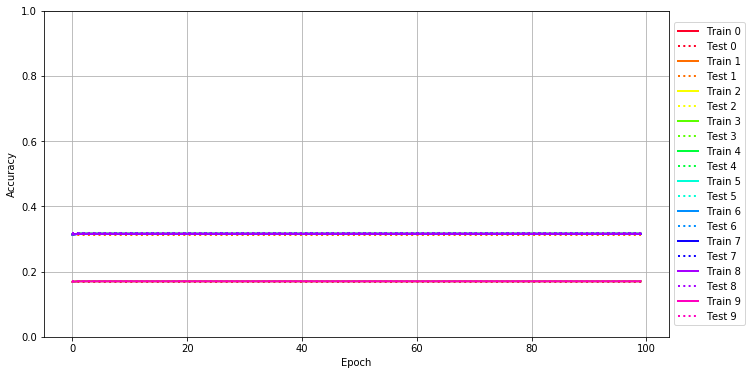

In [ ]:
plot_acc(history)

In [ ]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

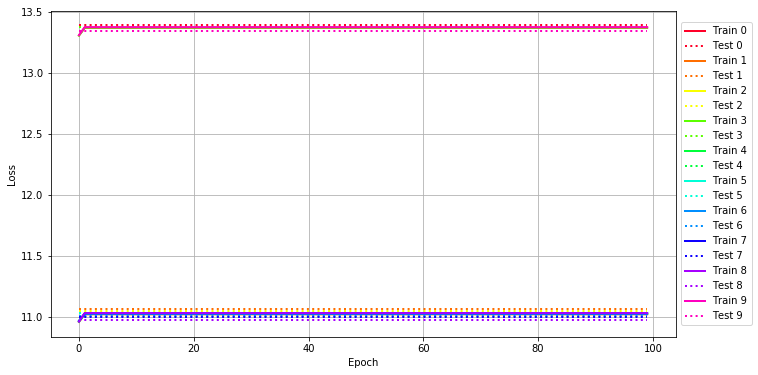

In [ ]:
plot_loss(history)

Plotting the confusion matrix


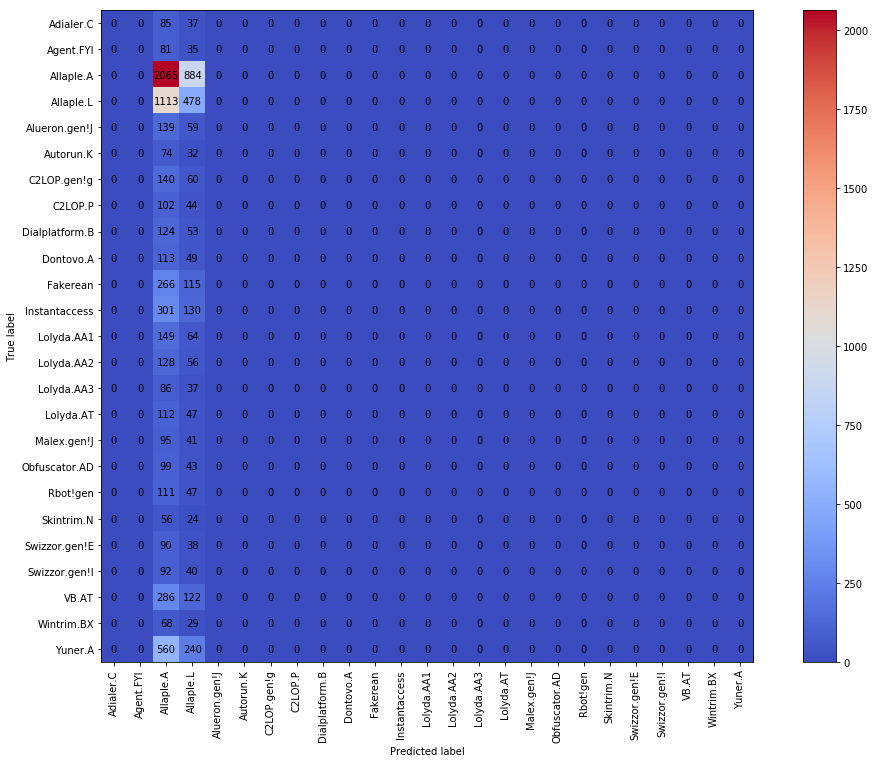

In [ ]:
print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(18, 12)
plt.imshow(conf_mat,interpolation='nearest',cmap='coolwarm')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(int(conf_mat[row][col])),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()

Plotting the confusion matrix normalized


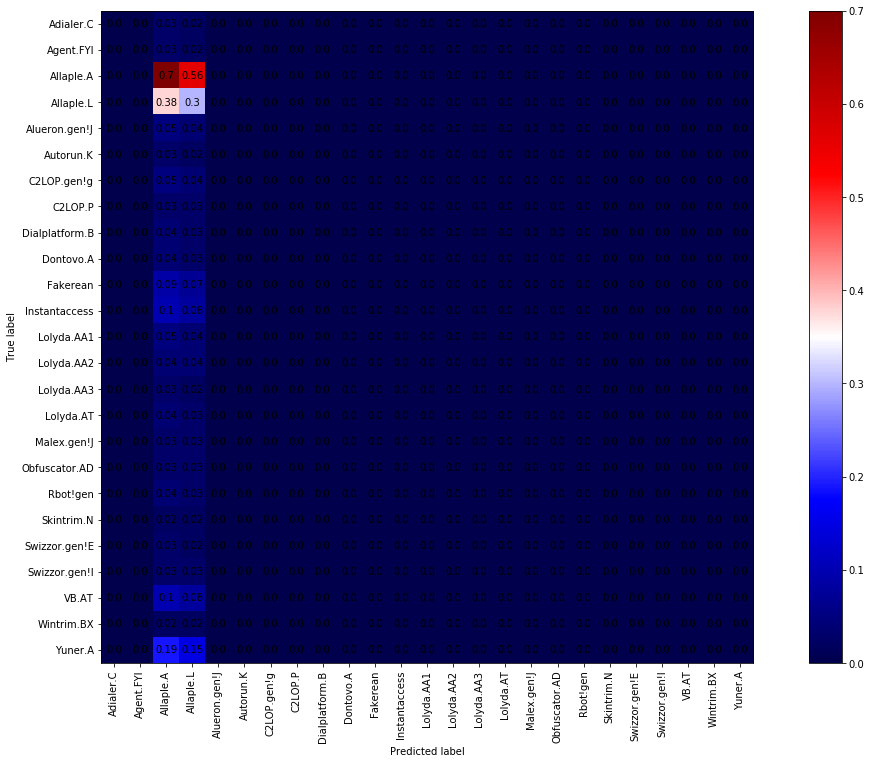

In [ ]:
print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/no_imgs  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(20, 12)
plt.imshow(conf_mat_norm,interpolation='nearest',cmap='seismic')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(conf_mat_norm[row][col]),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()

Plotting the confusion matrix normalized


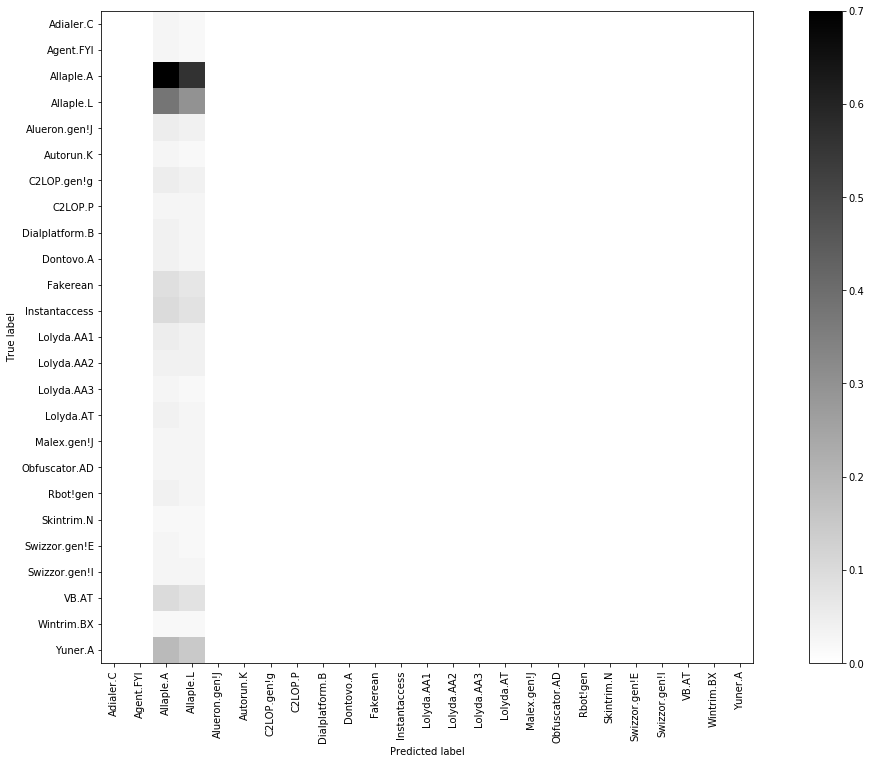

In [ ]:
print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/no_imgs  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(20, 12)
plt.imshow(conf_mat_norm,interpolation='nearest',cmap='binary')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()

Plotting the confusion matrix normalized


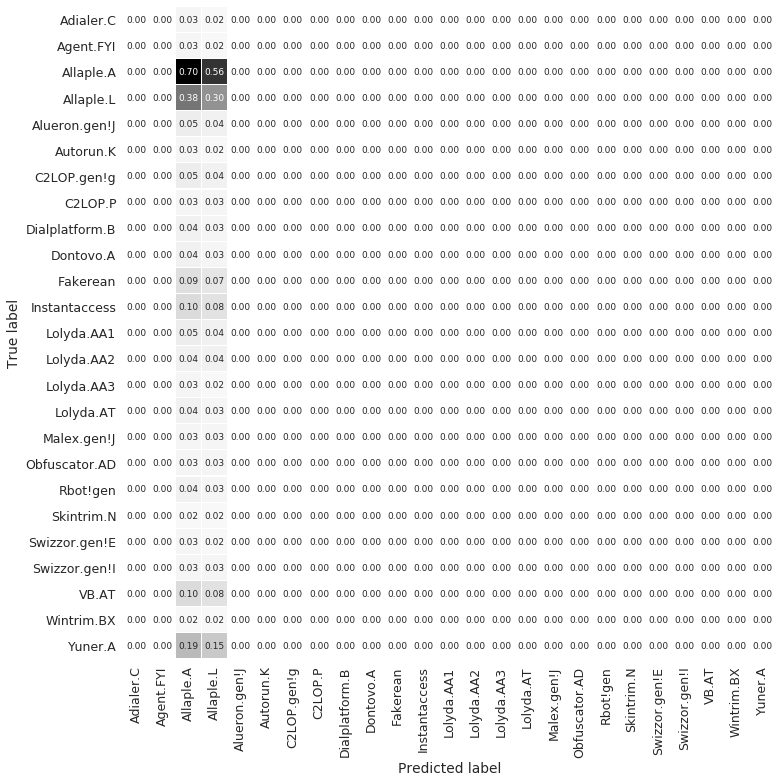

In [ ]:
import seaborn as sns

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure

figure = plt.gcf()
figure.set_size_inches(20, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 9}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
for h in history:
    print(h.history)

{'acc': [0.16845365737609019, 0.17047891351142497, 0.17047891350964975, 0.17047891350964975, 0.17047891351142497, 0.17047891350964975, 0.17047891351142497, 0.17047891351320019, 0.17047891350964975, 0.17047891351142497, 0.17047891350964975, 0.17047891351320019, 0.17047891352385147, 0.17047891351142497, 0.17047891351320019, 0.17047891351320019, 0.17047891351142497, 0.17047891351142497, 0.17047891351320019, 0.17047891351142497, 0.17047891350964975, 0.17047891351320019, 0.17047891351320019, 0.17047891352385147, 0.17047891351142497, 0.17047891350964975, 0.17047891352385147, 0.17047891351320019, 0.17047891351320019, 0.17047891352385147, 0.17047891351320019, 0.17047891351675062, 0.17047891350964975, 0.17047891351320019, 0.17047891351142497, 0.17047891351142497, 0.17047891351675062, 0.17047891351142497, 0.17047891351320019, 0.17047891351142497, 0.17047891351320019, 0.17047891352385147, 0.17047891352385147, 0.17047891351142497, 0.17047891352385147, 0.17047891351320019, 0.17047891351142497, 0.17

In [ ]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

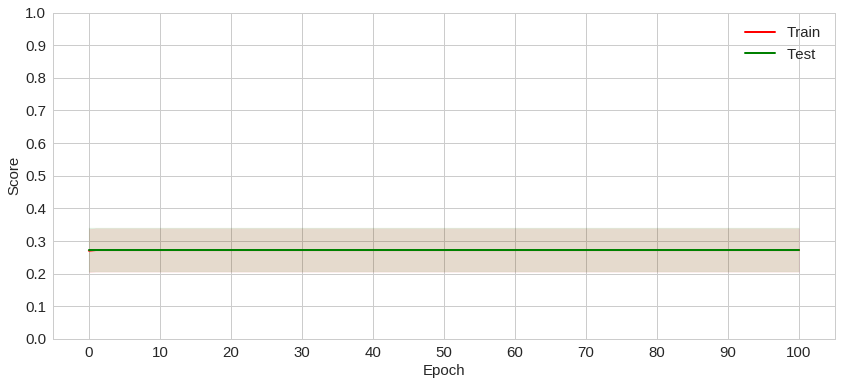

In [ ]:
plot_mean_acc(history)

In [ ]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

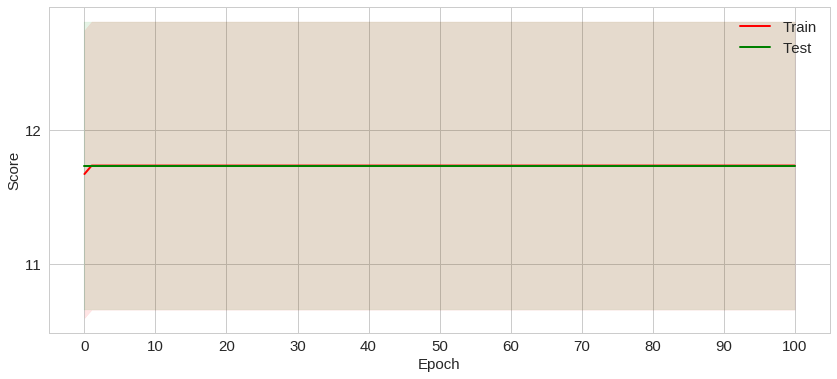

In [ ]:
plot_mean_loss(history)

In [2]:
history = [{'acc': [0.16845365737609019, 0.17047891351142497, 0.17047891350964975, 0.17047891350964975, 0.17047891351142497, 0.17047891350964975, 0.17047891351142497, 0.17047891351320019, 0.17047891350964975, 0.17047891351142497, 0.17047891350964975, 0.17047891351320019, 0.17047891352385147, 0.17047891351142497, 0.17047891351320019, 0.17047891351320019, 0.17047891351142497, 0.17047891351142497, 0.17047891351320019, 0.17047891351142497, 0.17047891350964975, 0.17047891351320019, 0.17047891351320019, 0.17047891352385147, 0.17047891351142497, 0.17047891350964975, 0.17047891352385147, 0.17047891351320019, 0.17047891351320019, 0.17047891352385147, 0.17047891351320019, 0.17047891351675062, 0.17047891350964975, 0.17047891351320019, 0.17047891351142497, 0.17047891351142497, 0.17047891351675062, 0.17047891351142497, 0.17047891351320019, 0.17047891351142497, 0.17047891351320019, 0.17047891352385147, 0.17047891352385147, 0.17047891351142497, 0.17047891352385147, 0.17047891351320019, 0.17047891351142497, 0.17047891351675062, 0.17047891351142497, 0.17047891352385147, 0.17047891351320019, 0.17047891351142497, 0.17047891351142497, 0.17047891351320019, 0.17047891352385147, 0.17047891351320019, 0.17047891351142497, 0.17047891351142497, 0.17047891351320019, 0.17047891351320019, 0.17047891351142497, 0.17047891351320019, 0.17047891352385147, 0.17047891351320019, 0.17047891351320019, 0.17047891352385147, 0.17047891350964975, 0.17047891350964975, 0.17047891351320019, 0.17047891351142497, 0.17047891351320019, 0.17047891350964975, 0.17047891351142497, 0.17047891351142497, 0.17047891351320019, 0.17047891350964975, 0.17047891351142497, 0.17047891351320019, 0.17047891351142497, 0.17047891350964975, 0.17047891352385147, 0.17047891350964975, 0.17047891351142497, 0.17047891351142497, 0.17047891351675062, 0.17047891351142497, 0.17047891351320019, 0.17047891352385147, 0.17047891351320019, 0.17047891352385147, 0.17047891351142497, 0.17047891351320019, 0.17047891351320019, 0.17047891351142497, 0.17047891352385147, 0.17047891350964975, 0.17047891351142497, 0.17047891351142497, 0.17047891350964975, 0.17047891351320019], 'val_acc': [0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693, 0.1693121693121693], 'val_loss': [13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812, 13.389105717088812], 'loss': [13.308245279177161, 13.370300053016384, 13.370300058469848, 13.370300022113428, 13.370300038473816, 13.370300073012414, 13.370300089372803, 13.370299987120376, 13.370300022113428, 13.3703000457451, 13.37030010209755, 13.370300088918349, 13.370300010752047, 13.370300053016384, 13.370300045290646, 13.370300133682189, 13.370300089372803, 13.370300096644087, 13.370300090054487, 13.370300082101521, 13.370300087554982, 13.370300053698067, 13.370300147088619, 13.370300010752047, 13.370300067558953, 13.370300022113428, 13.370300018023331, 13.370300082783203, 13.370300031884216, 13.370300090736169, 13.370300082783203, 13.370300098689135, 13.370300073012414, 13.37030001620551, 13.370300060287668, 13.370300074830237, 13.370300055061433, 13.3703000457451, 13.370300031884216, 13.370300089372803, 13.370300096189633, 13.370300112550021, 13.370300061651035, 13.370300067558953, 13.370300068922317, 13.370300045290646, 13.370300016659966, 13.370300025976297, 13.3703000457451, 13.370300018023331, 13.370300068240635, 13.370299980303546, 13.370300038473816, 13.370300045290646, 13.370300076193601, 13.370300053698067, 13.370300074830237, 13.370300002117398, 13.37030007437578, 13.370299994391658, 13.370300023931248, 13.3703000391555, 13.370300061651035, 13.370300024612932, 13.370299988256512, 13.370300076193601, 13.370300058469848, 13.370300109368834, 13.370300075511919, 13.370300031202532, 13.370300053698067, 13.370300123911402, 13.370300060287668, 13.370300111186655, 13.370300024612932, 13.37030004392728, 13.370300133000507, 13.370300010070364, 13.370300016659966, 13.370300000299578, 13.370300083464885, 13.370300094826266, 13.370300038473816, 13.370300060287668, 13.370299989619879, 13.370300031202532, 13.370300031884216, 13.370300076193601, 13.370300038019362, 13.370300047108467, 13.370300118457939, 13.370300060969351, 13.370300017341648, 13.370300067558953, 13.370300098007453, 13.370300094826266, 13.370300118457939, 13.370300038473816, 13.370300036655996, 13.370300059833212]}, 
{'acc': [0.3140407288885122, 0.3160652614206278, 0.31606526145257025, 0.3160652614206278, 0.31606526140731844, 0.3160652614206278, 0.31606526141175489, 0.31606526142772612, 0.31606526143127528, 0.3160652614206278, 0.31606526142772612, 0.31606526142772612, 0.3160652614206278, 0.31606526145966857, 0.3160652614206278, 0.31606526141175489, 0.3160652614206278, 0.31606526142772612, 0.31606526144547192, 0.31606526145966857, 0.3160652614206278, 0.3160652614206278, 0.31606526141352947, 0.31606526141175489, 0.31606526142772612, 0.31606526142772612, 0.31606526145966857, 0.31606526140288199, 0.31606526145966857, 0.3160652614206278, 0.31606526142772612, 0.3160652614206278, 0.31606526144547192, 0.31606526142772612, 0.31606526145257025, 0.31606526142772612, 0.31606526145257025, 0.31606526145966857, 0.31606526142772612, 0.3160652614206278, 0.3160652614206278, 0.3160652614206278, 0.31606526144547192, 0.31606526142772612, 0.3160652614206278, 0.3160652614206278, 0.31606526142772612, 0.31606526145966857, 0.31606526144547192, 0.3160652614206278, 0.31606526153065184, 0.31606526142772612, 0.31606526142772612, 0.3160652614206278, 0.31606526142772612, 0.3160652614206278, 0.31606526141352947, 0.3160652614206278, 0.31606526140731844, 0.31606526141175489, 0.3160652614206278, 0.3160652614383736, 0.31606526144547192, 0.31606526145257025, 0.31606526145966857, 0.31606526141352947, 0.3160652614206278, 0.3160652614206278, 0.31606526144547192, 0.3160652614206278, 0.31606526141175489, 0.3160652614206278, 0.31606526144547192, 0.3160652614383736, 0.3160652614206278, 0.31606526140731844, 0.31606526141175489, 0.31606526142772612, 0.31606526140731844, 0.31606526141175489, 0.3160652614206278, 0.31606526145257025, 0.3160652614206278, 0.31606526145257025, 0.31606526141175489, 0.31606526142772612, 0.31606526141352947, 0.31606526145966857, 0.3160652614206278, 0.31606526145966857, 0.31606526142772612, 0.3160652614206278, 0.3160652614206278, 0.31606526145257025, 0.31606526140731844, 0.3160652614206278, 0.31606526141175489, 0.3160652614206278, 0.31606526145966857, 0.31606526141175489], 'val_acc': [0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086], 'val_loss': [11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856], 'loss': [10.961356997788059, 11.023725383350136, 11.023725311344714, 11.023725361544077, 11.023725306688213, 11.023725332469335, 11.023725321566305, 11.023725323383477, 11.023725263700749, 11.023725317931962, 11.023725421510736, 11.023725381532964, 11.023725332469335, 11.023725252854508, 11.023725317931962, 11.023725343372362, 11.023725376081449, 11.023725396070336, 11.023725305893201, 11.023725325541367, 11.02372530339459, 11.023725317931962, 11.023725289197937, 11.023725293968013, 11.023725359726907, 11.023725294308733, 11.023725347347426, 11.023725342690923, 11.023725369153484, 11.023725317931962, 11.023725374264279, 11.023725376081449, 11.023725334967944, 11.02372535245822, 11.023725267732599, 11.02372531611479, 11.023725304076029, 11.023725289197937, 11.023725337920848, 11.023725296125903, 11.023725354275392, 11.023725357909735, 11.023725313161886, 11.023725381532964, 11.023725390618822, 11.02372533973802, 11.023725388801649, 11.023725311003995, 11.023725327699259, 11.023725347006705, 11.023725364383408, 11.023725374264279, 11.023725381532964, 11.02372533973802, 11.023725345189535, 11.023725357909735, 11.023725332810054, 11.02372533973802, 11.023725395388897, 11.02372538846093, 11.023725361544077, 11.023725422532896, 11.023725342236631, 11.02372541310632, 11.023725318272682, 11.02372530373531, 11.023725332469335, 11.023725360067626, 11.023725284087142, 11.023725354275392, 11.0237253521175, 11.023725325200648, 11.023725371311375, 11.023725313502606, 11.023725332469335, 11.023725315433351, 11.023725343372362, 11.02372531611479, 11.023725357569015, 11.023725336103677, 11.023725354275392, 11.023725260463912, 11.02372530339459, 11.023725347688146, 11.023725344848815, 11.023725366995592, 11.023725340078739, 11.023725347347426, 11.023725317931962, 11.023725354616111, 11.023725294308733, 11.023725390618822, 11.023725347006705, 11.02372539130026, 11.023725308164664, 11.02372530339459, 11.023725221281152, 11.023725230707729, 11.023725281929252, 11.023725279430641]}, 
{'acc': [0.31389120344590066, 0.31591477207577862, 0.31591477206868368, 0.31591477205272006, 0.31591477206158874, 0.31591477205272006, 0.31591477207577862, 0.31591477211480085, 0.31591477207577862, 0.31591477207577862, 0.31591477205449381, 0.31591477205272006, 0.31591477205138974, 0.31591477205183316, 0.31591477206868368, 0.31591477206868368, 0.31591477207577862, 0.31591477207577862, 0.31591477207577862, 0.31591477206868368, 0.31591477207577862, 0.315914772059815, 0.31591477206158874, 0.31591477205272006, 0.31591477206868368, 0.31591477205272006, 0.31591477207577862, 0.31591477206158874, 0.31591477205272006, 0.31591477210770591, 0.31591477210770591, 0.31591477207577862, 0.31591477206868368, 0.31591477211480085, 0.31591477207577862, 0.31591477210770591, 0.31591477205272006, 0.31591477206868368, 0.31591477206868368, 0.31591477211480085, 0.31591477206158874, 0.31591477207577862, 0.31591477205272006, 0.31591477207577862, 0.31591477206868368, 0.31591477205183316, 0.31591477210061092, 0.31591477206868368, 0.31591477206868368, 0.315914772059815, 0.31591477205272006, 0.31591477211480085, 0.31591477206158874, 0.31591477209351598, 0.31591477206868368, 0.315914772059815, 0.31591477210061092, 0.31591477210770591, 0.31591477206868368, 0.315914772059815, 0.31591477206868368, 0.315914772059815, 0.31591477205272006, 0.31591477206868368, 0.31591477205183316, 0.31591477205272006, 0.31591477207577862, 0.31591477207577862, 0.31591477207577862, 0.31591477206158874, 0.31591477206868368, 0.315914772059815, 0.31591477207577862, 0.31591477211480085, 0.31591477206868368, 0.31591477205138974, 0.31591477207577862, 0.315914772059815, 0.31591477206868368, 0.31591477206868368, 0.315914772059815, 0.31591477206868368, 0.31591477206868368, 0.31591477210770591, 0.31591477206868368, 0.315914772059815, 0.31591477206868368, 0.31591477207577862, 0.315914772059815, 0.31591477207577862, 0.31591477206158874, 0.31591477207577862, 0.31591477206868368, 0.31591477205272006, 0.31591477205272006, 0.31591477206158874, 0.31591477206868368, 0.31591477206158874, 0.31591477209351598, 0.31591477206868368], 'val_acc': [0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896], 'val_loss': [11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498], 'loss': [10.965776747031633, 11.026150920819333, 11.026150949426158, 11.02615092660881, 11.026150907310555, 11.026150890282684, 11.026150935349785, 11.026150930581981, 11.026150920819333, 11.026150993471585, 11.026150966908105, 11.02615095566971, 11.026150938641839, 11.026150925587137, 11.026150891304356, 11.026150913100032, 11.026150957145459, 11.026150891758434, 11.026150906288883, 11.026150913100032, 11.026150942615009, 11.026150939663511, 11.026150929106231, 11.026150948404485, 11.026150931263095, 11.026150962934935, 11.026150906288883, 11.026150950901906, 11.026150984730611, 11.026150931092817, 11.026150931092817, 11.02615100073681, 11.026150920365257, 11.026150966908105, 11.026150949880234, 11.026150960153716, 11.026150904813134, 11.026150949426158, 11.026150905834808, 11.026150930581981, 11.026150936371456, 11.026150935349785, 11.026150912078359, 11.026150906288883, 11.026150876773906, 11.026150925587137, 11.026150953399327, 11.026150905834808, 11.026150971221833, 11.026150932398286, 11.02615092660881, 11.026150937847206, 11.026150958167131, 11.026150994833815, 11.026150927630482, 11.026150932398286, 11.026150909807978, 11.026150876603628, 11.026150927630482, 11.026150925133061, 11.026150963956608, 11.026150903337387, 11.026150991995836, 11.026150905834808, 11.026150969178488, 11.026150948404485, 11.026150891758434, 11.026150978941134, 11.026150906288883, 11.026150936371456, 11.026150891304356, 11.026150990520087, 11.02615098620636, 11.026150930581981, 11.026150942160932, 11.026150953172289, 11.026150993471585, 11.026150932398286, 11.026151007547959, 11.026150898569583, 11.026150903337387, 11.026150920365257, 11.026151000282734, 11.026150923827592, 11.026150934895707, 11.026150946928736, 11.02615084044778, 11.026150978941134, 11.02615089607216, 11.026150906288883, 11.026150936371456, 11.026150877227982, 11.026150949426158, 11.026150853956558, 11.026150912078359, 11.026150907310555, 11.026150884039131, 11.026150929106231, 11.026150962140301, 11.026150884039131]}, 
{'acc': [0.16851124598535061, 0.17041532788037772, 0.17041532784491142, 0.17041532786264457, 0.17041532786264457, 0.17041532784491142, 0.17041532784491142, 0.17041532786087127, 0.17041532784491142, 0.17041532785998459, 0.17041532786087127, 0.17041532786264457, 0.17041532785998459, 0.17041532783072491, 0.17041532784491142, 0.17041532783072491, 0.17041532788037772, 0.17041532788037772, 0.17041532786264457, 0.17041532791584399, 0.17041532784491142, 0.17041532785998459, 0.17041532784845806, 0.17041532784491142, 0.17041532785909794, 0.17041532784491142, 0.17041532785998459, 0.17041532784491142, 0.17041532784491142, 0.17041532784491142, 0.17041532785998459, 0.17041532788037772, 0.17041532785998459, 0.17041532784845806, 0.17041532785998459, 0.17041532784491142, 0.17041532784491142, 0.17041532784845806, 0.17041532786264457, 0.17041532788037772, 0.17041532784491142, 0.17041532785998459, 0.17041532784491142, 0.17041532785998459, 0.17041532784491142, 0.17041532786264457, 0.17041532786264457, 0.17041532786264457, 0.17041532786087127, 0.17041532784491142, 0.17041532786087127, 0.17041532786087127, 0.17041532788037772, 0.17041532784845806, 0.17041532786264457, 0.17041532785909794, 0.17041532786264457, 0.17041532788037772, 0.17041532786264457, 0.17041532788037772, 0.17041532786264457, 0.17041532786087127, 0.17041532783072491, 0.17041532789811087, 0.17041532786264457, 0.17041532785998459, 0.17041532786087127, 0.17041532786087127, 0.17041532786264457, 0.17041532784491142, 0.17041532786264457, 0.17041532786264457, 0.17041532788037772, 0.17041532783072491, 0.17041532785909794, 0.17041532786087127, 0.17041532786087127, 0.17041532786264457, 0.17041532784491142, 0.17041532788037772, 0.17041532786087127, 0.17041532786264457, 0.17041532786087127, 0.17041532786087127, 0.17041532785998459, 0.17041532786087127, 0.17041532786264457, 0.17041532786087127, 0.17041532786264457, 0.17041532786087127, 0.17041532788037772, 0.17041532785998459, 0.17041532784491142, 0.17041532785998459, 0.17041532788037772, 0.17041532784491142, 0.17041532788037772, 0.17041532786087127, 0.17041532786087127, 0.17041532784845806], 'val_acc': [0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488], 'val_loss': [13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957], 'loss': [13.305120965689119, 13.371324927554618, 13.371324911892705, 13.371324985095125, 13.371325019256254, 13.371324926419696, 13.371324938790337, 13.371324938222878, 13.371324970000673, 13.371325010290377, 13.37132488011491, 13.371324953884791, 13.371324937655418, 13.37132497896655, 13.371324960580827, 13.371324906331591, 13.371324978399089, 13.371324920291123, 13.371324992358621, 13.37132496500702, 13.371324933683193, 13.37132491586493, 13.371324921426043, 13.371324926419696, 13.371324958878445, 13.37132491699985, 13.37132491586493, 13.371324904629208, 13.371324897365714, 13.37132495331733, 13.371324930391921, 13.37132494208161, 13.371324986343538, 13.371324972270514, 13.371325022661019, 13.371324938790337, 13.371324991791161, 13.371324972270514, 13.37132499020227, 13.37132490576413, 13.371324977264168, 13.371324937655418, 13.371324911892705, 13.371325003026881, 13.37132486831173, 13.371324970568132, 13.371324844932351, 13.371324932094304, 13.371324916432389, 13.371324940946689, 13.37132495274987, 13.371324909168894, 13.371324949345105, 13.371324906899051, 13.371324934250653, 13.371324900770476, 13.371324881249832, 13.371324913027626, 13.371324968411782, 13.371324862183155, 13.371324975675279, 13.371324967276861, 13.371324928122078, 13.371324969546704, 13.371324975675279, 13.371324920972075, 13.371325018121333, 13.371324967276861, 13.371324881249832, 13.371324880682371, 13.371324939357798, 13.371324970568132, 13.371325000189577, 13.371324971703054, 13.371324980668932, 13.371324945486373, 13.371324930959382, 13.371324919723662, 13.371324933683193, 13.371324971135593, 13.371324967276861, 13.371324912460166, 13.371325003594341, 13.371324981803854, 13.371324908601434, 13.371324938222878, 13.37132499020227, 13.371324829270439, 13.371324939357798, 13.371324930959382, 13.371325007453073, 13.371324935499066, 13.371324931526843, 13.371324937655418, 13.371325000189577, 13.371324991791161, 13.371324949345105, 13.37132488011491, 13.371324981803854, 13.371324870581573]}, 
{'acc': [0.31342217992851135, 0.3158019990622572, 0.31580199904807232, 0.31580199904807232, 0.31580199907644202, 0.31580199904807232, 0.31580199910481166, 0.31580199905516476, 0.31580199904807232, 0.31580199904807232, 0.3158019990338875, 0.3158019990622572, 0.3158019990622572, 0.31580199901970268, 0.31580199904807232, 0.3158019990338875, 0.31580199904807232, 0.31580199907644202, 0.31580199907644202, 0.31580199907644202, 0.31580199904807232, 0.31580199904807232, 0.31580199907644202, 0.31580199905516476, 0.31580199907644202, 0.3158019990338875, 0.31580199904807232, 0.31580199910481166, 0.31580199907644202, 0.31580199904807232, 0.31580199909062684, 0.31580199905516476, 0.31580199905516476, 0.31580199907644202, 0.3158019990622572, 0.31580199904807232, 0.3158019990622572, 0.31580199904807232, 0.3158019990622572, 0.3158019991331813, 0.31580199907644202, 0.31580199904807232, 0.3158019990338875, 0.31580199905516476, 0.31580199910481166, 0.31580199901970268, 0.3158019990338875, 0.31580199905516476, 0.31580199904807232, 0.3158019990622572, 0.3158019990622572, 0.31580199907644202, 0.31580199904807232, 0.31580199907644202, 0.31580199904807232, 0.31580199907644202, 0.31580199904807232, 0.31580199910481166, 0.31580199904807232, 0.31580199905516476, 0.31580199905161854, 0.31580199905516476, 0.31580199907644202, 0.31580199910481166, 0.31580199910481166, 0.3158019990622572, 0.31580199907644202, 0.31580199910481166, 0.3158019990622572, 0.31580199910481166, 0.3158019990622572, 0.31580199905516476, 0.3158019990622572, 0.31580199909062684, 0.31580199907644202, 0.31580199910481166, 0.3158019990622572, 0.3158019990622572, 0.31580199901970268, 0.31580199905516476, 0.31580199904807232, 0.31580199907644202, 0.31580199905516476, 0.31580199907644202, 0.3158019990622572, 0.3158019990338875, 0.3158019990338875, 0.31580199910481166, 0.3158019990622572, 0.31580199910481166, 0.3158019990622572, 0.31580199901970268, 0.31580199907644202, 0.31580199910481166, 0.31580199909062684, 0.31580199904807232, 0.31580199907644202, 0.31580199905516476, 0.31580199904807232, 0.31580199910481166], 'val_acc': [0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432], 'val_loss': [11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087], 'loss': [10.969747448466835, 11.027968592328268, 11.027968605945702, 11.027968642258859, 11.027968593236096, 11.027968664046755, 11.027968638627543, 11.027968676756361, 11.027968685834649, 11.027968627733596, 11.027968616839649, 11.027968581434319, 11.027968691735538, 11.027968615931821, 11.027968664046755, 11.027968614570076, 11.027968595959583, 11.027968607761359, 11.027968607761359, 11.027968527872412, 11.027968588696952, 11.027968649521492, 11.027968644074518, 11.027968647705833, 11.027968571448202, 11.027968674940702, 11.027968569632543, 11.027968667678071, 11.027968585973465, 11.027968617747478, 11.027968603676129, 11.027968620924879, 11.02796862818751, 11.027968633180571, 11.027968601860472, 11.027968671309386, 11.027968650429321, 11.027968547844649, 11.027968630910998, 11.027968659961525, 11.027968687650308, 11.027968627733596, 11.02796858052649, 11.027968669493728, 11.027968616839649, 11.027968703083399, 11.027968658145866, 11.027968633180571, 11.027968627733596, 11.027968601860472, 11.027968663592841, 11.027968578710833, 11.027968584157806, 11.027968680387676, 11.027968671309386, 11.027968593236096, 11.027968598683071, 11.027968609577018, 11.027968576895175, 11.027968635450142, 11.027968619563136, 11.027968618655306, 11.027968629549255, 11.027968570994286, 11.027968566001228, 11.027968667224156, 11.027968626825768, 11.027968674940702, 11.027968599590899, 11.027968682203333, 11.027968599590899, 11.027968635450142, 11.027968648159748, 11.027968603676129, 11.027968578710833, 11.027968616839649, 11.027968643166689, 11.027968652698892, 11.027968652244978, 11.027968620924879, 11.027968620470965, 11.027968687650308, 11.027968582342149, 11.027968611392675, 11.027968587335208, 11.027968625464023, 11.027968616839649, 11.027968689465965, 11.027968611846589, 11.027968653152808, 11.027968604583958, 11.027968644982346, 11.027968636811886, 11.027968558738596, 11.027968632726656, 11.027968639535374, 11.027968622286624, 11.02796865859978, 11.027968719424321, 11.027968602314386]}, 
{'acc': [0.31389814375526048, 0.31580199909062684, 0.31580199905516476, 0.3158019990622572, 0.31580199907644202, 0.31580199907644202, 0.31580199904807232, 0.31580199907644202, 0.31580199905516476, 0.3158019990622572, 0.31580199907644202, 0.3158019990622572, 0.3158019990338875, 0.3158019990622572, 0.3158019990622572, 0.31580199904807232, 0.3158019990622572, 0.31580199904807232, 0.3158019990622572, 0.31580199904807232, 0.3158019990622572, 0.31580199905516476, 0.31580199907644202, 0.3158019990622572, 0.31580199910481166, 0.31580199905516476, 0.31580199910481166, 0.31580199904807232, 0.31580199904807232, 0.31580199904807232, 0.3158019990622572, 0.3158019990622572, 0.31580199907644202, 0.31580199909062684, 0.3158019990338875, 0.31580199904807232, 0.31580199904807232, 0.31580199910481166, 0.31580199905516476, 0.3158019990338875, 0.3158019990622572, 0.31580199904807232, 0.31580199910481166, 0.3158019990338875, 0.3158019990622572, 0.31580199907644202, 0.31580199905161854, 0.31580199904807232, 0.31580199907644202, 0.31580199904807232, 0.31580199907644202, 0.31580199910481166, 0.31580199910481166, 0.3158019990338875, 0.31580199904807232, 0.31580199910481166, 0.31580199907644202, 0.31580199905161854, 0.31580199907644202, 0.3158019990622572, 0.31580199909062684, 0.3158019991331813, 0.31580199904807232, 0.31580199907644202, 0.3158019990622572, 0.31580199901970268, 0.3158019990622572, 0.31580199907644202, 0.31580199905516476, 0.3158019990622572, 0.31580199910481166, 0.31580199899133304, 0.31580199904807232, 0.3158019990622572, 0.31580199905516476, 0.31580199910481166, 0.31580199907644202, 0.3158019990622572, 0.31580199910481166, 0.31580199910481166, 0.31580199904807232, 0.31580199904807232, 0.31580199904807232, 0.31580199907644202, 0.3158019990338875, 0.31580199904807232, 0.31580199907644202, 0.31580199901970268, 0.31580199901970268, 0.31580199907644202, 0.3158019990622572, 0.31580199904807232, 0.31580199910481166, 0.31580199907644202, 0.31580199904807232, 0.3158019990622572, 0.31580199904807232, 0.31580199904807232, 0.31580199904807232, 0.31580199907644202], 'val_acc': [0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432], 'val_loss': [11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087], 'loss': [10.965688335504037, 11.027968632726656, 11.027968618655306, 11.027968652698892, 11.027968626825768, 11.027968593236096, 11.027968707622545, 11.027968636811886, 11.027968625917939, 11.027968616385735, 11.027968600498728, 11.027968674486788, 11.027968573263859, 11.027968667224156, 11.027968536496786, 11.027968617747478, 11.027968575533432, 11.027968584157806, 11.027968616385735, 11.027968598683071, 11.027968659961525, 11.027968577349089, 11.027968583249978, 11.02796864543626, 11.027968638627543, 11.02796858461172, 11.027968660415439, 11.027968667678071, 11.027968671309386, 11.027968700359914, 11.027968630910998, 11.027968521971523, 11.027968629549255, 11.027968632726656, 11.027968636357972, 11.027968569632543, 11.027968603222215, 11.027968616839649, 11.027968599136985, 11.027968602314386, 11.027968548752478, 11.02796869309728, 11.027968558738596, 11.027968621832708, 11.027968594597839, 11.027968629549255, 11.027968583249978, 11.027968591420438, 11.02796861502399, 11.027968555107281, 11.027968600498728, 11.027968616839649, 11.027968624102281, 11.027968660415439, 11.02796858052649, 11.027968660415439, 11.027968665862412, 11.027968619563136, 11.027968644074518, 11.027968674486788, 11.027968596413498, 11.027968638173629, 11.027968642258859, 11.027968636811886, 11.027968652698892, 11.027968652244978, 11.027968616385735, 11.027968673125045, 11.027968610030932, 11.027968621378793, 11.027968602314386, 11.027968613662248, 11.027968634996228, 11.027968640897116, 11.027968602768301, 11.027968558738596, 11.027968636811886, 11.027968638173629, 11.027968551475965, 11.027968616839649, 11.027968642258859, 11.027968664046755, 11.027968613208333, 11.027968702175571, 11.027968551475965, 11.027968613208333, 11.027968625917939, 11.027968615931821, 11.027968623194452, 11.027968564185569, 11.027968669947644, 11.027968642258859, 11.027968674940702, 11.027968702175571, 11.027968627733596, 11.027968640897116, 11.027968634996228, 11.027968639535374, 11.027968562369912, 11.027968680387676]}, 
{'acc': [0.31327307326355852, 0.3156517602567101, 0.31565176022835395, 0.3156517602567101, 0.3156517602567101, 0.31565176024253205, 0.31565176022835395, 0.31565176022835395, 0.31565176024253205, 0.31565176028506625, 0.31565176028506625, 0.31565176022835395, 0.3156517602567101, 0.3156517602567101, 0.31565176028506625, 0.31565176022835395, 0.3156517602567101, 0.3156517602567101, 0.31565176034177861, 0.3156517602567101, 0.3156517602567101, 0.3156517602567101, 0.31565176022835395, 0.3156517602567101, 0.3156517602567101, 0.31565176028506625, 0.31565176024253205, 0.31565176028506625, 0.31565176022835395, 0.3156517602567101, 0.31565176028506625, 0.31565176028506625, 0.31565176022835395, 0.3156517602567101, 0.3156517603134224, 0.31565176022835395, 0.31565176028506625, 0.31565176028506625, 0.31565176028506625, 0.31565176028506625, 0.31565176024253205, 0.31565176028506625, 0.315651760235443, 0.31565176024253205, 0.31565176028506625, 0.31565176022835395, 0.3156517602567101, 0.31565176022835395, 0.3156517602567101, 0.31565176024253205, 0.3156517602567101, 0.3156517602567101, 0.31565176028506625, 0.31565176024253205, 0.31565176022835395, 0.3156517602567101, 0.3156517602567101, 0.31565176022835395, 0.31565176024253205, 0.3156517601999978, 0.31565176028506625, 0.31565176028506625, 0.31565176028506625, 0.31565176022835395, 0.31565176022835395, 0.3156517602567101, 0.31565176028506625, 0.31565176034177861, 0.3156517602567101, 0.31565176024253205, 0.3156517602567101, 0.31565176028506625, 0.3156517602567101, 0.31565176028506625, 0.31565176022835395, 0.31565176022835395, 0.31565176022835395, 0.3156517602567101, 0.31565176024253205, 0.3156517602567101, 0.31565176022835395, 0.31565176022835395, 0.3156517602567101, 0.31565176022835395, 0.31565176022835395, 0.3156517602567101, 0.31565176022835395, 0.31565176028506625, 0.31565176024253205, 0.31565176022835395, 0.31565176028506625, 0.31565176022835395, 0.31565176022835395, 0.31565176028506625, 0.31565176028506625, 0.31565176028506625, 0.31565176024253205, 0.31565176024253205, 0.31565176022835395, 0.3156517602567101], 'val_acc': [0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927], 'val_loss': [11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082], 'loss': [10.972070782894638, 11.030390125133104, 11.030390192280487, 11.030390239465135, 11.030390195910075, 11.030390126040501, 11.030390264872253, 11.030390199539664, 11.030390118781325, 11.030390237650341, 11.030390165058575, 11.030390204984046, 11.030390210428429, 11.030390212243223, 11.030390157799399, 11.030390168688163, 11.030390139651457, 11.030390149632826, 11.03039019137309, 11.03039019772487, 11.030390188650898, 11.030390190465694, 11.030390185021311, 11.030390164151179, 11.030390168688163, 11.030390194095281, 11.030390220409796, 11.030390175039942, 11.030390163243782, 11.030390137836664, 11.03039013602187, 11.030390196817473, 11.030390155984605, 11.030390166873369, 11.030390260335267, 11.030390103355575, 11.030390186836105, 11.030390182299119, 11.030390157799399, 11.030390157799399, 11.030390133299678, 11.030390244909517, 11.030390226761575, 11.030390205891443, 11.030390225854179, 11.030390231298561, 11.03039014509584, 11.030390167780766, 11.030390130577487, 11.030390169595561, 11.030390130577487, 11.030390159614193, 11.030390157799399, 11.030390162336383, 11.030390158706796, 11.030390217687605, 11.030390183206517, 11.030390202261854, 11.030390162336383, 11.030390186836105, 11.030390201354457, 11.030390193187884, 11.030390244909517, 11.030390146910634, 11.030390137836664, 11.03039014509584, 11.030390196817473, 11.030390220409796, 11.030390212243223, 11.03039021315062, 11.030390253983487, 11.030390116966531, 11.030390195910075, 11.030390165058575, 11.030390146910634, 11.030390185021311, 11.030390141466251, 11.030390152355016, 11.030390176854738, 11.030390183206517, 11.030390226761575, 11.030390209521032, 11.03039014509584, 11.030390148725427, 11.030390226761575, 11.030390217687605, 11.03039015416981, 11.030390194095281, 11.030390155077207, 11.030390155984605, 11.030390114244339, 11.030390151447619, 11.03039015416981, 11.03039013874406, 11.030390114244339, 11.03039025942787, 11.03039019137309, 11.030390184113914, 11.030390112429545, 11.03039022222459]}, 
{'acc': [0.31391200954083454, 0.31557669443976438, 0.31557669446102649, 0.31557669446102649, 0.31557669444685177, 0.31557669446811382, 0.3155766944539391, 0.31557669443976438, 0.31557669451063791, 0.31557669444685177, 0.3155766944539391, 0.31557669443976438, 0.31557669459568616, 0.31557669446102649, 0.3155766944539391, 0.31557669446102649, 0.3155766945177253, 0.31557669444685177, 0.31557669446102649, 0.31557669460986087, 0.31557669453898735, 0.31557669452481263, 0.31557669452481263, 0.3155766944539391, 0.31557669453898735, 0.3155766944539391, 0.31557669452481263, 0.3155766944539391, 0.3155766944539391, 0.3155766944539391, 0.31557669452481263, 0.31557669453898735, 0.31557669446102649, 0.31557669452481263, 0.31557669452481263, 0.31557669451063791, 0.31557669446102649, 0.3155766944539391, 0.3155766944539391, 0.31557669442558967, 0.31557669443976438, 0.31557669443976438, 0.3155766944539391, 0.31557669444685177, 0.31557669453898735, 0.31557669444685177, 0.31557669443976438, 0.31557669453898735, 0.3155766944202742, 0.315576694411415, 0.3155766944539391, 0.315576694411415, 0.31557669452481263, 0.31557669441495867, 0.3155766944539391, 0.3155766944539391, 0.31557669452481263, 0.31557669443976438, 0.31557669443622072, 0.31557669446102649, 0.3155766944539391, 0.31557669443976438, 0.3155766944539391, 0.31557669452481263, 0.31557669451063791, 0.3155766944539391, 0.31557669446102649, 0.3155766945177253, 0.31557669444685177, 0.31557669444685177, 0.31557669443976438, 0.315576694422046, 0.3155766944539391, 0.3155766944539391, 0.31557669449646325, 0.31557669452481263, 0.31557669452481263, 0.315576694422046, 0.3155766944539391, 0.31557669446811382, 0.31557669453898735, 0.31557669452481263, 0.31557669451063791, 0.31557669452481263, 0.31557669443976438, 0.3155766944539391, 0.31557669446102649, 0.31557669442558967, 0.31557669442913339, 0.31557669444685177, 0.3155766944539391, 0.31557669444685177, 0.31557669451063791, 0.31557669446811382, 0.315576694422046, 0.31557669443976438, 0.31557669444685177, 0.3155766945177253, 0.31557669443976438, 0.31557669443976438], 'val_acc': [0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402], 'val_loss': [10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729], 'loss': [10.965512275695801, 11.03160010075881, 11.031600088058273, 11.031600117088074, 11.03160015700405, 11.031600028184307, 11.031600082615185, 11.031600086243909, 11.03160009304777, 11.031600103253558, 11.031600089872635, 11.031600078986459, 11.031600051317431, 11.031600102573172, 11.031600097130084, 11.031600066285922, 11.031600149293007, 11.031600019112496, 11.031600095315722, 11.031600171065358, 11.031600077172097, 11.031600114139733, 11.031600117768459, 11.031600075357733, 11.031600040884845, 11.031600140674787, 11.031600041565232, 11.031600104387534, 11.031600111644986, 11.031600133417335, 11.031600063337581, 11.031600120716798, 11.031600138860423, 11.031600114139733, 11.031600070595033, 11.031600078532868, 11.031600117088074, 11.031600129788611, 11.03160010801626, 11.031600120263207, 11.031600049956658, 11.031600144303511, 11.031600111644986, 11.031600077172097, 11.031600048142296, 11.031600135231699, 11.031600112325371, 11.031600106201898, 11.031600098264061, 11.031600109377033, 11.031600002783232, 11.031600087604682, 11.031600103933945, 11.031600109830622, 11.031600097130084, 11.031600118902436, 11.031600070595033, 11.031600093501361, 11.031600136365675, 11.03160005177102, 11.031600118902436, 11.03160011527371, 11.031600089872635, 11.031600114139733, 11.03160012933502, 11.031600155189686, 11.031600088058273, 11.031600098490857, 11.031600066285922, 11.0316002078062, 11.031600078986459, 11.031600067419898, 11.031600068100284, 11.031600133417335, 11.031600098831049, 11.031600114139733, 11.031600106882284, 11.031600078986459, 11.031600126159885, 11.031600035441759, 11.031600127974249, 11.031600056080132, 11.03160012207757, 11.031600048822682, 11.031600076038121, 11.031600104387534, 11.031600095315722, 11.031600050637044, 11.031600091686997, 11.031600215063651, 11.031600082615185, 11.031600098944448, 11.031600147478645, 11.031600144303511, 11.03160010075881, 11.03160006447156, 11.031600084429547, 11.031600156550459, 11.03160010801626, 11.03160010801626]}, 
{'acc': [0.31376277646685202, 0.31542666989265949, 0.31542666988557555, 0.31542666989974349, 0.31542666997766733, 0.31542666997766733, 0.31542666987849155, 0.31542666999183527, 0.31542666987849155, 0.31542666989265949, 0.31542666990682749, 0.31542666996349938, 0.31542666988557555, 0.31542666996349938, 0.31542666989265949, 0.31542666997766733, 0.31542666987849155, 0.31542666989265949, 0.31542666986432355, 0.31542666988557555, 0.31542666997766733, 0.31542666995641538, 0.31542666986432355, 0.31542666997766733, 0.31542666988557555, 0.31542666995641538, 0.31542666986078161, 0.31542666996349938, 0.31542667006267516, 0.31542666997766733, 0.31542666996349938, 0.31542666983598766, 0.31542666997058333, 0.31542666994933138, 0.31542666997766733, 0.31542666996349938, 0.31542666989974349, 0.31542666996349938, 0.31542666997766733, 0.31542666996349938, 0.31542666988557555, 0.31542666987849155, 0.31542666995641538, 0.31542666987849155, 0.31542666990682749, 0.31542666999183527, 0.31542666987849155, 0.31542666996349938, 0.31542666999183527, 0.31542666997766733, 0.31542666997766733, 0.31542666988557555, 0.31542666988557555, 0.31542666987849155, 0.31542666989265949, 0.31542666994933138, 0.31542666984661361, 0.31542666994933138, 0.31542666997766733, 0.31542666989265949, 0.31542666997058333, 0.31542666987849155, 0.31542666996349938, 0.31542666987849155, 0.31542666987849155, 0.31542666989265949, 0.31542666997766733, 0.31542666987849155, 0.31542666997766733, 0.31542666983598766, 0.31542666986432355, 0.31542666987849155, 0.31542666990682749, 0.31542666997766733, 0.31542666997766733, 0.31542666985015561, 0.31542666986078161, 0.31542667006267516, 0.31542666987849155, 0.31542666989265949, 0.31542666996349938, 0.31542666989974349, 0.31542666997766733, 0.31542666997058333, 0.31542666997766733, 0.31542666996349938, 0.31542666997766733, 0.31542666989265949, 0.31542666997766733, 0.31542666987849155, 0.31542666989265949, 0.31542666997766733, 0.31542666987849155, 0.31542666987849155, 0.31542666986078161, 0.31542666989265949, 0.31542666997766733, 0.31542666989974349, 0.31542666995641538, 0.31542666997058333], 'val_acc': [0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894], 'val_loss': [10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237], 'loss': [10.966073475740911, 11.034018152027025, 11.034018226380526, 11.034018226153838, 11.034018212099214, 11.034018197591214, 11.034018224793714, 11.034018132078526, 11.034018166761713, 11.034018177189338, 11.034018209832338, 11.034018150440213, 11.034018284412527, 11.034018215726213, 11.034018278745339, 11.034018219353214, 11.034018188523714, 11.034018166535025, 11.034018213912713, 11.034018197364526, 11.034018161321214, 11.034018203031714, 11.034018228420713, 11.034018161321214, 11.034018262650527, 11.034018282825715, 11.034018179002839, 11.034018273758214, 11.034018239301714, 11.034018139559214, 11.034018201218213, 11.034018196231088, 11.034018264690713, 11.034018186936901, 11.034018154067214, 11.034018193964213, 11.034018276931839, 11.034018273758214, 11.034018204845214, 11.034018193964213, 11.034018237261526, 11.034018213686027, 11.034018159507713, 11.034018246555714, 11.034018202578338, 11.034018226380526, 11.034018203031714, 11.034018179456213, 11.034018219126526, 11.034018175829214, 11.034018241115215, 11.034018211872526, 11.034018211872526, 11.034018144999713, 11.034018195551026, 11.034018208698901, 11.034018226153838, 11.034018237714902, 11.034018241115215, 11.034018220713339, 11.034018206658713, 11.034018181269714, 11.034018201218213, 11.034018261063714, 11.034018232047714, 11.034018184443338, 11.034018204845214, 11.034018220940027, 11.034018190337214, 11.034018196004402, 11.034018170388713, 11.034018144999713, 11.034018260610338, 11.034018175829214, 11.034018255623213, 11.034018228647401, 11.034018215272839, 11.034018181496402, 11.034018177416026, 11.034018166535025, 11.034018222980214, 11.034018284185839, 11.034018201218213, 11.034018213912713, 11.034018197591214, 11.034018186710213, 11.034018248369215, 11.034018235221339, 11.034018233861214, 11.034018181269714, 11.034018242475339, 11.034018248369215, 11.034018246555714, 11.034018170162026, 11.034018215272839, 11.034018224567026, 11.034018212099214, 11.034018233407838, 11.034018170615401, 11.034018192150713]}, 
{'acc': [0.16836977186311788, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286, 0.17015209125475286], 'val_acc': [0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469, 0.1722643553629469], 'val_loss': [13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616, 13.341522109340616], 'loss': [13.309584751781856, 13.375567860476417, 13.375567751692275, 13.375567780701379, 13.37556783871959, 13.37556774444, 13.375567798832071, 13.375567816962761, 13.375567806084346, 13.375567795205932, 13.375567816962761, 13.375567835093451, 13.375567795205932, 13.375567802458209, 13.37556783871959, 13.375567802458209, 13.375567777075242, 13.375567878607107, 13.375567867728694, 13.375567853224142, 13.375567824215036, 13.375567824215036, 13.375567860476417, 13.375567806084346, 13.375567860476417, 13.375567809710484, 13.375567816962761, 13.375567806084346, 13.375567802458209, 13.375567773449104, 13.375567802458209, 13.375567831467313, 13.375567780701379, 13.37556783871959, 13.375567882233247, 13.375567802458209, 13.375567896737799, 13.375567867728694, 13.375567845971865, 13.375567824215036, 13.375567802458209, 13.375567733561585, 13.375567780701379, 13.375567845971865, 13.37556783871959, 13.375567773449104, 13.375567802458209, 13.37556783871959, 13.375567787953656, 13.375567798832071, 13.375567824215036, 13.375567831467313, 13.375567773449104, 13.37556783871959, 13.375567780701379, 13.375567802458209, 13.375567845971865, 13.375567798832071, 13.375567885859384, 13.375567864102555, 13.375567809710484, 13.375567791579794, 13.375567795205932, 13.375567824215036, 13.37556783871959, 13.375567864102555, 13.375567813336623, 13.375567795205932, 13.375567824215036, 13.375567831467313, 13.375567748066137, 13.375567798832071, 13.375567795205932, 13.375567780701379, 13.37556783871959, 13.375567831467313, 13.375567806084346, 13.375567784327519, 13.375567809710484, 13.375567824215036, 13.375567816962761, 13.375567824215036, 13.375567780701379, 13.375567802458209, 13.375567831467313, 13.375567824215036, 13.375567835093451, 13.375567751692275, 13.375567853224142, 13.375567824215036, 13.375567816962761, 13.375567802458209, 13.375567773449104, 13.37556783871959, 13.375567816962761, 13.375567845971865, 13.375567831467313, 13.375567860476417, 13.375567820588898, 13.375567849598003]}]

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7,  label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

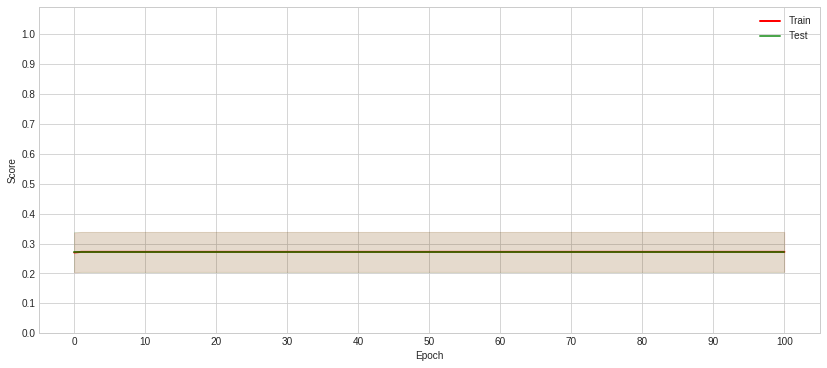

In [8]:
plot_mean_acc(history)

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-3.9,17.9))
    plt.show()

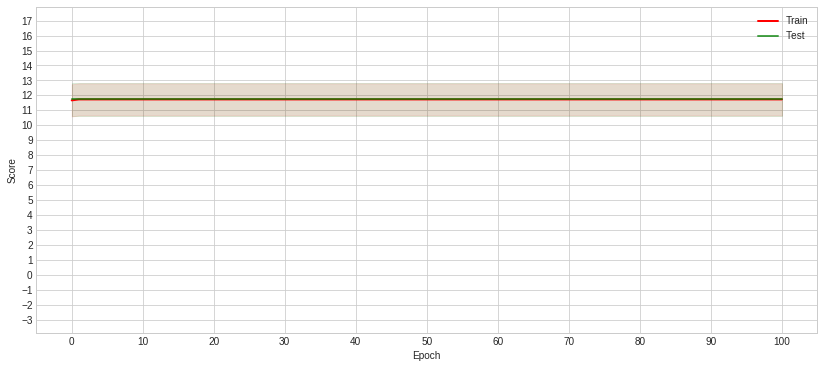

In [10]:
plot_mean_loss(history)